<a href="https://colab.research.google.com/github/parkerburchett/Numerai/blob/main/maxDataPoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of this notebook is to set up modular ways to test and submit lots of variations on the light Gradient Boost Machine, to the data about them and then be able to identify them later and Identify patterns.

Methods needed.

1. You need a way to go from a list of hyper params, ( in the all_data_file) to a trained model.
2. You need a way to save to disk (or cloud or where ever) the all_stats dict object.
3. You need a way ot put this on to any computer and then post that data to a sql database somewhere



https://microsoft.github.io/FLAML/

You might want to expirment with this library for auto ML tuning

https://docs.dask.org/en/latest/
this is for distributed computing


Pick the range for the hyper paramaters.







Notebook this is based on: 
https://www.kaggle.com/code1110/numerai-tournament


In [ ]:
!pip install numerapi
import numerapi

In [ ]:
import numpy as np
import pandas as pd
import os, sys
import gc
import pathlib
import json
import datetime
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from scipy.stats import spearmanr # -P I think this is corr. 
import joblib

# model
import lightgbm as lgb
import xgboost as xgb
import operator

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Methods to Gather and Clean Incoming Data

In [ ]:
def cast_eras_as_int(x): # this is used to cast the eras from strings to ints
    try:
        return int(x[3:]) # the eras look like era03 or era123
    except:
        return 1000

# unclear if numerapi.download_latest_data() would be faster
def read_data(data='train'):
    # get data 
    if data == 'train':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz')

        # The test data is significantly larger.
        # test data is the live tournment data
    elif data == 'test':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz')
        
    
    # features
    feature_cols = df.columns[df.columns.str.startswith('feature')]
    
    # map to int, to reduce the memory demand
    mapping = {0.0 : 0, 0.25 : 1, 0.5 : 2, 0.75 : 3, 1.0 : 4} # this is very clever -P
    for c in feature_cols:
        df[c] = df[c].map(mapping).astype(np.uint8)
        
    df["era"] = df["era"].apply(cast_eras_as_int)# also cast era to int
    return df

### Load the Data from Numerai

In [ ]:
%%time
# load in the Training data
train_data = read_data('train')
print(train_data.shape)

(501808, 314)
CPU times: user 1min 24s, sys: 4.87 s, total: 1min 29s
Wall time: 1min 31s


In [ ]:
%%time
# the testing data is the tournament data. There is validation data in this column
# takes like 10 minutes to run.
tournament_data = read_data('test')
print(tournament_data.shape)

(1693046, 314)
CPU times: user 5min 8s, sys: 26.3 s, total: 5min 34s
Wall time: 5min 41s


### Extract the Validation from the tournament_data


In [ ]:
# validation is derived from the live tournament data
valid = tournament_data[tournament_data["data_type"] == "validation"].reset_index(drop = True) # when the data_type == Validation that means there is already a target for those vectors.
# those are the last spot check on the model's vectors 
print(valid.columns) # valid is a df where
# validation split
# valid.loc[valid["era"] > 180, "valid2"] = True # Every era after 180 is in validation
# valid.loc[valid["era"] <= 180, "valid2"] = False # Every era before is not in the validation set. 


Index(['id', 'era', 'data_type', 'feature_intelligence1',
       'feature_intelligence2', 'feature_intelligence3',
       'feature_intelligence4', 'feature_intelligence5',
       'feature_intelligence6', 'feature_intelligence7',
       ...
       'feature_wisdom38', 'feature_wisdom39', 'feature_wisdom40',
       'feature_wisdom41', 'feature_wisdom42', 'feature_wisdom43',
       'feature_wisdom44', 'feature_wisdom45', 'feature_wisdom46', 'target'],
      dtype='object', length=314)


### Drop Data_type_column

In [ ]:
# remove data_type to save memory
train_data.drop(columns=["data_type"], inplace=True)
valid.drop(columns=["data_type"], inplace=True) #
tournament_data.drop(columns=["data_type"], inplace=True)
print('The number of records: train {:,}, test {:,}'.format(train_data.shape[0], tournament_data.shape[0])) # df.shape[0] is number of rows.

The number of records: train 501,808, test 1,693,046


## Determine features

In [ ]:
FEATURES = [f for f in tournament_data.columns.values.tolist() if 'feature' in f] # Column Names that contains 'feature'
TARGET = tournament_data.columns[tournament_data.columns.str.startswith('target')].values.tolist()[0] # the string 'target'

### ModelStats Object

1. Stores the Trained Model
2. Stores the Hyper Parameters
3. Stores the Validation Scores

In [ ]:
class ModelStats():
  """
  An object that tracks Hyper parmas, Time Costs and Scores. 
  Use this to track your the relationship between hyper paramters training time, and 
  """
  def __init__(self, model, scores:dict, total_time):
        self.model = model # A Trained Model. Look into memory problems
        self.hyperparams = model.get_params() # dictionary of hyper params used to train the model
        self.scores = scores # dictionary of the CORR Scores. From score_summary().
        self.total_time = total_time
        self.all_stats_dict = None # untested. 


  def create_all_stats_dict(self):
    """
    In order to do Hyper Parameter tuning. I need to convert this model into a array of values. 
    """
    if self.all_stats_dict == None:
      DECIMALS = 4 # how many decimals do you want to track. 4 is good enough I think. 
      all_stats_dict = {}
      all_stats_dict['total_time'] = self.total_time
      all_stats_dict.update(self.hyperparams)
      all_stats_dict.update(self.scores)

      for key in all_stats_dict.keys():
          try:
            all_stats_dict[key] = round(all_stats_dict[key],DECIMALS)# make more readable
          except:
            all_stats_dict[key] = all_stats_dict[key]

      self.all_stats_dict = all_stats_dict


  def headlines(self):
    """
    # Get a subset of scores that are the high level summary of the model
    """
    self.create_all_stats_dict()
    summary_dict = {}
    summary_dict['correlation'] = self.all_stats_dict['correlation']
    summary_dict['corr_sharpe'] = self.all_stats_dict['corr_sharpe']
    summary_dict['max_depth'] = self.all_stats_dict['max_depth']
    summary_dict['n_estimators'] = self.all_stats_dict['n_estimators']
    summary_dict['boosting_type'] = self.all_stats_dict['boosting_type']
    summary_dict['total_time'] = self.all_stats_dict['total_time']  
    summary_dict['num_leaves'] = self.all_stats_dict['num_leaves']
    summary_dict['learning_rate'] = self.all_stats_dict['learning_rate']
    return summary_dict
    

def train_LGBMRegressor(params: dict, train_data): # there is not really a clear cell to put this method
  """
  Inputs: a dict of hyper paramaters for the model, 
  train_data: a pd.DataFrame of the training Data

  Returns a trained model based on the parmas
  """
  model = lgb.LGBMRegressor(**params) 
  model.fit(train_data[FEATURES], train_data[TARGET])
  return model

#### Methods to Determine Validation Scores

1. I did not write these. I added the English comments

In [ ]:
# naming conventions
PREDICTION_NAME = 'prediction'
TARGET_NAME = TARGET # 'target is the string named 'target'
# EXAMPLE_PRED = 'example_prediction'

# ---------------------------
# Functions
# ---------------------------
def valid4score(valid : pd.DataFrame, pred : np.ndarray, load_example: bool=True, save : bool=False) -> pd.DataFrame:
    """
    Generate new valid pandas dataframe for computing scores
    
    :INPUT:
    - valid : pd.DataFrame extracted from tournament data (data_type='validation')
    
    """
    valid_df = valid.copy() # the validation dataframe you use this to test the CORR and other values

    # Your model creates an array of floats [0,1] rank method converst them in a list of ints. 

    # your lis tof ints is then compared to their list of ints. 
    valid_df['prediction'] = pd.Series(pred).rank(pct=True, method="first") # pred is the array of predictions your model creates for the set of validation vectors.  
    # I am unsure if this preds is a float only only between 0,1,2,3,4. 
    valid_df.rename(columns={TARGET: 'target'}, inplace=True)
    
    # I don't know what the load example boolean is. I think you can use this to save predictions.
    if load_example:
        valid_df[EXAMPLE_PRED] = pd.read_csv(EXP_DIR + 'valid_df.csv')['prediction'].values
    
    if save==True:
        valid_df.to_csv(OUTPUT_DIR + 'valid_df.csv', index=False)
        print('Validation dataframe saved!')
    
    return valid_df

def compute_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation

    THIS IS WHAT YOU ARE PRIMARILY PAID ON 
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    
    """
    # this uses Person Correilation. 
    # I You are paid on spearman corrilation. That is where the ratio of change is important not the raw amount of change
    # see: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/
    return np.corrcoef(valid_df["target"], valid_df['prediction'])[0, 1]

def compute_max_drawdown(validation_correlations : pd.Series):
    """
    Compute max drawdown
    
    :INPUT:
    - validation_correaltions : pd.Series
    """
    
    rolling_max = (validation_correlations + 1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -(rolling_max - daily_value).max()
    
    return max_drawdown

def compute_val_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    
    # all validation
    correlation = compute_corr(valid_df)
    #print("rank corr = {:.4f}".format(correlation))
    return correlation
    
def compute_val_sharpe(valid_df : pd.DataFrame):
    """
    Compute sharpe ratio for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    d = valid_df.groupby('era')[['target', 'prediction']].corr().iloc[0::2,-1].reset_index()
    me = d['prediction'].mean()
    sd = d['prediction'].std()
    max_drawdown = compute_max_drawdown(d['prediction'])
    #print('sharpe ratio = {:.4f}, corr mean = {:.4f}, corr std = {:.4f}, max drawdown = {:.4f}'.format(me / sd, me, sd, max_drawdown))
    
    return me / sd, me, sd, max_drawdown
    
def feature_exposures(valid_df : pd.DataFrame):
    """
    Compute feature exposure
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    feature_names = [f for f in valid_df.columns
                     if f.startswith("feature")]
    exposures = []
    for f in feature_names:
        fe = spearmanr(valid_df['prediction'], valid_df[f])[0]
        exposures.append(fe)
    return np.array(exposures)

def max_feature_exposure(fe : np.ndarray):
    return np.max(np.abs(fe))

def feature_exposure(fe : np.ndarray):
    return np.sqrt(np.mean(np.square(fe)))

def compute_val_feature_exposure(valid_df : pd.DataFrame):
    """
    Compute feature exposure for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    fe = feature_exposures(valid_df)
    fe1, fe2 = feature_exposure(fe), max_feature_exposure(fe)
    #print('feature exposure = {:.4f}, max feature exposure = {:.4f}'.format(fe1, fe2))
     
    return fe1, fe2

# to neutralize a column in a df by many other columns
#         I have no idea what this method does. -P. need to read about it and write up a link to it. 
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()


# to neutralize any series by any other series
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def get_feature_neutral_mean(df):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [PREDICTION_NAME],
                                          feature_cols)[PREDICTION_NAME]
    scores = df.groupby("era").apply(
        lambda x: np.corrcoef(x["neutral_sub"].rank(pct=True, method="first"), x[TARGET_NAME])).mean()
    return np.mean(scores)

def compute_val_mmc(valid_df : pd.DataFrame):    
    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in valid_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[PREDICTION_NAME])),
                                   pd.Series(unif(x[EXAMPLE_PRED])))
        mmc_scores.append(np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2)) # I have no idea what htis line does (0.29 ** 2)
        corr_scores.append(np.corrcoef(unif(x[PREDICTION_NAME]).rank(pct=True, method="first"), x[TARGET_NAME]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    val_mmc_sharpe = val_mmc_mean / val_mmc_std
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
    corr_plus_mmc_mean = np.mean(corr_plus_mmcs)

    #print("MMC Mean = {:.6f}, MMC Std = {:.6f}, CORR+MMC Sharpe = {:.4f}".format(val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe))

    # Check correlation with example predictions
    corr_with_example_preds = np.corrcoef(valid_df[EXAMPLE_PRED].rank(pct=True, method="first"),
                                          valid_df[PREDICTION_NAME].rank(pct=True, method="first"))[0, 1]
    #print("Corr with example preds: {:.4f}".format(corr_with_example_preds))
    
    return val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe, corr_with_example_preds


# this is the main method. The rest are just called interanlly. 
def score_summary(valid_df : pd.DataFrame):
    score_dict = {}
    
    try:
        score_dict['correlation'] = compute_val_corr(valid_df)
    except:
        print('ERR: computing correlation')
    try:
        score_dict['corr_sharpe'], score_dict['corr_mean'], score_dict['corr_std'], score_dict['max_drawdown'] = compute_val_sharpe(valid_df)
    except:
        print('ERR: computing sharpe')
    try:
        score_dict['feature_exposure'], score_dict['max_feature_exposure'] = compute_val_feature_exposure(valid_df)
    except:
        print('ERR: computing feature exposure')
    # try:
    #     score_dict['mmc_mean'], score_dict['mmc_std'], score_dict['corr_mmc_sharpe'], score_dict['corr_with_example_xgb'] = compute_val_mmc(valid_df)
    # except:
    #     print('ERR: computing MMC')
    
    return score_dict

### Main to train and track time, hyper parmas and scores.

In [ ]:
def train_validate_store(params, train_data, validation_data,features):
  """
  Train a model, get validation scores, create a Model_Stats Object.
  """
  start_time = datetime.datetime.now()
  my_model = train_LGBMRegressor(params=params, train_data=train_data)
  my_predictions = my_model.predict(validation_data[features])
  valid_df = valid4score(validation_data, my_predictions, load_example=False, save=False)
  my_scores = score_summary(valid_df)
  total_time = (datetime.datetime.now() - start_time).total_seconds() # untested
  my_model_stats = ModelStats(model=my_model, scores=my_scores,total_time=total_time)
  return my_model_stats 

def save_my_model_stats(ModelStatsObject):
  # best is just to cast it as a list. and append it to the file in your google drive
  # establish Gdrive connetction. 
  # convert values to a list of tupeles.
  # look at file. If no header:
    #add header based on alphabeticly sorted list of col names.
  # .append (stats.values())
  return 0
              

### Conclustions:

Basic tests show n_estimators, num_leaves follow a basic pattern of sharpe increase then pleateuing out

Now testign estimators at 30k learning rate at .001 and leave in increments of 5. 

In [ ]:
saving_all_stats =[]

# Testing some theories. 

Lets keep all but 1 variable constant and then create a Dataframe of all the scores for that changing variable.


To start set n_estiamtors =1000 and try all the leaves between 2, and 32. 

save results to a dataframe.

You need to let this run for like 30 minutes. 




The validation df might be a constant You might need to only make it once at set up and then just reference it each time

In [ ]:
%%time
param_set = [ {
            'n_estimators': 1000,
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'max_depth': 4, # best max depth is 4
            'learning_rate': .032,#.032 is best with sharpe >1 and depth =4
            'feature_fraction': .095, # MIGHT BE WRONG. NEED TO DOUBLE CHECK. 
            'seed': i 
              } for i in range(1,20)] 

all_scores_rf = []


for param in param_set: # this is fully parralizeable 
  model_stats =  train_validate_store(param,
                             train_data=train_data,
                             validation_data=valid,
                             features=FEATURES)
  headlines = model_stats.headlines() # this also gets creates the all_stats_dict
  print(model_stats.all_stats_dict)
  all_scores_rf.append(model_stats.all_stats_dict)
  saving_all_stats.append(model_stats.all_stats_dict) # use this for later r
  # you should just write all the stat dicts to a dictionary that you store in main memory. 
  # while you run these tests. 

{'total_time': 332.7463, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.032, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 3000, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 1, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'feature_fraction': 0.36, 'seed': 1, 'correlation': 0.0221, 'corr_sharpe': 0.8758, 'corr_mean': 0.0226, 'corr_std': 0.0259, 'max_drawdown': -0.0544, 'feature_exposure': 0.0662, 'max_feature_exposure': 0.2651}
{'total_time': 337.3581, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.032, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 3000, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'regression', 'random_s

In [ ]:
len(saving_all_stats)


9

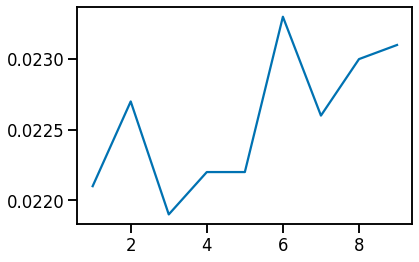

In [ ]:
all_scores_df = pd.DataFrame(all_scores_rf) # untested. might be broken
all_scores_df.to_csv('/content/drive/MyDrive/allstats3.csv',index=False)
all_scores_df.head(50) # you might want to see the derative of each of these variables with repect to the independent.

y = all_scores_df.correlation
x = all_scores_df.seed
plt.plot(x,y)

9

In [ ]:
y = all_scores_df.correlation
x = all_scores_df.max_depth
plt.plot(x,y)

# Submit to Numerai


1. Create a prediction list.
2. Link those predictions with the tournment data
3. Write the id, prediction to a csv file.
4. Use numerai wrapper to submit that .csv file as your current model. 
5. This submits for MRQUANTSALOT and TUTMODEL



### Methods to handle submission

In [ ]:
def load_api_creds_into_dict(): # works
  """
    Read creds.json and return a dictionary of your API keys.
  """
  creds  = open('creds.json','r') # refactor this to point at your google drive. 
  api_keys_dict = json.load(creds)
  creds.close()
  return api_keys_dict


def open_api_access(): # works
    """
    Read in my private key from creds.json and return the numerai api wrapper
    """
    api_keys_dict = load_api_creds_into_dict()
    my_secret_key = api_keys_dict['secret_key']
    my_public_id = api_keys_dict['public_id']
    napi = numerapi.NumerAPI(secret_key=my_secret_key, public_id=my_public_id)
    return napi


def create_id_prediction_df(tournament_data: pd.DataFrame, model_predictions : np.ndarray): # works
    """
    Create a dataframe that looks like 
    id,prediction
    asdfads,.5429
    asdfaddsss,.5051
    ...
    """
    predictions_df = tournament_data["id"].to_frame() # get all the Ids and cast them to a Dataframe
    predictions_df[PREDICTION_NAME] = model_predictions #add your predictions to the id frame
    return predictions_df # data frame of id, prediction


def write_predictions_to_file(prediction_df: pd.DataFrame): # works
    my_file_name = 'myPredictions.csv'
    try:
      out_location = open(my_file_name, 'x')
    except:
      out_location = open(my_file_name, 'w')

    prediction_df.to_csv(out_location, index=False)
    out_location.close()
    return my_file_name 


def run_model_and_create_prediction_file(model_object, tournament_data: pd.DataFrame, features: list):
  """
    This stitches everything together.

    Pass it a trained model and the tournament data set, the list of feature columns
    1. Does preditions
    2. write the predictions to a file.
    3. returns the name fo the file where my predictions are saved data is saved
  """
  model_predictions = model_object.predict(tournament_data[features])
  prediction_df = create_id_prediction_df(tournament_data,model_predictions)
  file_with_predictions = write_predictions_to_file(prediction_df)
  return file_with_predictions


def submit_predictions_to_numerai(filename_of_predictions, sumbit_model_id):
    napi = open_api_access() # open a connection to the numerai API with your creds.json file
    submission_id = napi.upload_predictions(filename_of_predictions, model_id=sumbit_model_id)
    print(f'You successfully submitted for {sumbit_model_id}')
    print(type(submission_id))
    return submission_id

print('your helper methods work correctly')
    

In [ ]:
api_keys_dict = load_api_creds_into_dict()
mrquantsalot_model_id = api_keys_dict['mr_quants_model_id']
tut_model_model_id = api_keys_dict['tutmodel_model_id']
PREDICTION_NAME = "prediction" # this is the header of the csv file you are creating
OUTPUT_DIR = '' # just the root of your local folder in this instance of google colab

### Run and submit MRQUANTSALOT


In [ ]:
%%time
if want_to_submit:
  mr_quants_file_with_predictions = run_model_and_create_prediction_file(mr_quants_model, tournament_data, features)
  numerai_submission_id_mrQ = submit_predictions_to_numerai(mr_quants_file_with_predictions, mrquantsalot_model_id)

### Run and submit TUT_MODEL

In [ ]:
%%time
if want_to_submit:
  tut_model_file_with_predictions = run_model_and_create_prediction_file(tut_model, tournament_data, features)
  numerai_submission_id_tut = submit_predictions_to_numerai(tut_model_file_with_predictions, tut_model_model_id)

## The params I am using now. No clear reason for these over another model. 

Default num_leaves =31


In [ ]:
param_set = [{
            'n_estimators': 500*i,
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'max_depth': 4, # max depth of each random forest
            'learning_rate': 0.013, # the size of the step between trees
            'feature_fraction': 0.095, # what % of features each tree will consider. you should root this at sqrt(310)/ 310 ~0.058
            'seed': 42 # a random seed.
            }for i in range(30,60,5)]

# i expect overfitting as the n_estimatros gets larger so the sharpe and correlatino scores will go down after this point. 

# so far is matching thesroy. 

#~ 5k estimators seems about right.


# tut_parmas = {
#             'n_estimators': 3000,
#             'objective': 'regression',
#             'boosting_type': 'gbdt',
#             'max_depth': 4,
#             'learning_rate': 0.013, 
#             'feature_fraction': 0.095,
#             'seed': 42
#             } 


# this version of the param gets CORR = .0255 and a sharpe of .97
for param in param_set: # this is fully parralizeable 
  model_stats =  train_validate_store(param,
                             train_data=train_data,
                             validation_data=valid,
                             features=FEATURES)
  headlines = model_stats.headlines() # this also gets creates the all_stats_dict
  print(model_stats.all_stats_dict)
  all_scores.append(model_stats.all_stats_dict)

{'total_time': 255.1076, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.013, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 5500, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 1, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'feature_fraction': 0.095, 'seed': 42, 'correlation': 0.0255, 'corr_sharpe': 0.9774, 'corr_mean': 0.0259, 'corr_std': 0.0265, 'max_drawdown': -0.0573, 'feature_exposure': 0.0747, 'max_feature_exposure': 0.2652}
{'total_time': 359.9538, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.013, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 8000, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'regression', 'random